In [1]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import numpy as np
from scipy.stats import zscore, skew, kurtosis
from sklearn.feature_selection import mutual_info_regression
from category_encoders import MEstimateEncoder
from sklearn.model_selection import KFold, cross_val_score



Exploratory Data Analysis 

In [2]:
df=pd.read_csv('data.csv') 

Data Exploration & Preparation


In [3]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

In [5]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261
std,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000
50%,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000
75%,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000


Data Preprocessing 

In [6]:
df[['floors', 'bathrooms', 'bedrooms']] = df[['floors', 'bathrooms', 'bedrooms']].astype('int')

In [7]:
#Identify Missing Data
df.isnull().sum()


date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

Handling Outliers

In [8]:
price_skewness = skew(df['price'])
price_kurtosis = kurtosis(df['price'])

print(f"Skewness: {price_skewness}, Kurtosis: {price_kurtosis}")

Skewness: 24.78284782965085, Kurtosis: 1043.216027112282


In [9]:
out = []
def Winsorisation_outliers(df):
    q1 = np.percentile(df, 1)
    q3 = np.percentile(df, 99)
    for i in df:
        if i > q3 or i < q1:
            out.append(i)
    print("Outliers:",out)
Winsorisation_outliers(df['price'])

Outliers: [2384000.0, 2280000.0, 3200000.0, 2400000.0, 2238888.0, 2555000.0, 2100000.0, 2700000.0, 2150000.0, 2453500.0, 3100000.0, 2750000.0, 2400000.0, 3710000.0, 2400000.0, 2700000.0, 7062500.0, 2888000.0, 2250000.0, 4668000.0, 2027000.0, 2475000.0, 4489000.0, 3000000.0, 2200000.0, 2110000.0, 2400000.0, 2075000.0, 2466350.0, 2300000.0, 2065000.0, 3800000.0, 2300000.0, 2367000.0, 2271150.0, 2147500.0, 2351956.0, 2458000.0, 2180000.0, 2680000.0, 2321000.0, 12899000.0, 2110000.0, 2199900.0, 26590000.0, 2560498.33333]


In [10]:
out.sort()
print(out)

[2027000.0, 2065000.0, 2075000.0, 2100000.0, 2110000.0, 2110000.0, 2147500.0, 2150000.0, 2180000.0, 2199900.0, 2200000.0, 2238888.0, 2250000.0, 2271150.0, 2280000.0, 2300000.0, 2300000.0, 2321000.0, 2351956.0, 2367000.0, 2384000.0, 2400000.0, 2400000.0, 2400000.0, 2400000.0, 2453500.0, 2458000.0, 2466350.0, 2475000.0, 2555000.0, 2560498.33333, 2680000.0, 2700000.0, 2700000.0, 2750000.0, 2888000.0, 3000000.0, 3100000.0, 3200000.0, 3710000.0, 3800000.0, 4489000.0, 4668000.0, 7062500.0, 12899000.0, 26590000.0]


In [11]:
q1 = df['price'].quantile(0.25)
q3 = df['price'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
m = np.median(df['price'])
for i in df['price']:
    if i > Upper_tail or i < Lower_tail:
        df['price']= df['price'].replace(i,m)

In [12]:
q1 = df['price'].quantile(0.25)
q3 = df['price'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
m = np.median(df['sqft_living'])
for i in df['price']:
    if i > Upper_tail or i < Lower_tail:
        df['sqft_living']= df['sqft_living'].replace(i,m)

In [13]:
q1 = df['price'].quantile(0.25)
q3 = df['price'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
m = np.median(df['sqft_living'])
for i in df['price']:
    if i > Upper_tail or i < Lower_tail:
        df['sqft_lot']= df['sqft_lot'].replace(i,m)

In [14]:
q1 = df['price'].quantile(0.25)
q3 = df['price'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
m = np.median(df['sqft_living'])
for i in df['sqft_above']:
    if i > Upper_tail or i < Lower_tail:
        df['sqft_above']= df['sqft_above'].replace(i,m)

In [15]:
q1 = df['price'].quantile(0.25)
q3 = df['price'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
m = np.median(df['sqft_basement'])
for i in df['price']:
    if i > Upper_tail or i < Lower_tail:
        df['sqft_basement']= df['sqft_basement'].replace(i,m)

In [16]:
price_skewness = skew(df['price'])
price_kurtosis = kurtosis(df['price'])

print(f"Skewness: {price_skewness}, Kurtosis: {price_kurtosis}")

Skewness: 0.6577588698681901, Kurtosis: 0.25165921323224794


In [17]:

(df['price'] == 0).sum()

49

In [18]:
df['price']= df['price'].replace(0,np.nan)

In [19]:
df['price'] = df['price'].fillna(value = df['price'].median())

Feature Engineering

In [20]:
# Function to create Z-Score
def make_mi_score(x,y):
    x = x.copy()
    for colname in x.select_dtypes(['object','category']):
        x[colname], _ = x[colname].factorize()
        
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in x.dtypes]
    mi_score = mutual_info_regression(x, y, discrete_features=discrete_features, random_state=42)
    mi_score = pd.Series(mi_score, name='Mutual Information Score', index=x.columns)
    mi_score = mi_score.sort_values(ascending=False)
    return mi_score

In [21]:
X = df.drop(columns=['price'])
y = df[['price']]

mi_score = make_mi_score(X, y)
mi_score

c:\Users\Jonathan.Otieno\AppData\Local\miniforge3\envs\arup-env\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


street           1.146393
statezip         0.436646
city             0.300513
sqft_living      0.263995
sqft_above       0.192721
bathrooms        0.151297
sqft_lot         0.142954
yr_built         0.080490
bedrooms         0.077208
floors           0.053404
sqft_basement    0.052547
view             0.050374
yr_renovated     0.017698
waterfront       0.009360
date             0.006636
condition        0.004014
country          0.000000
Name: Mutual Information Score, dtype: float64

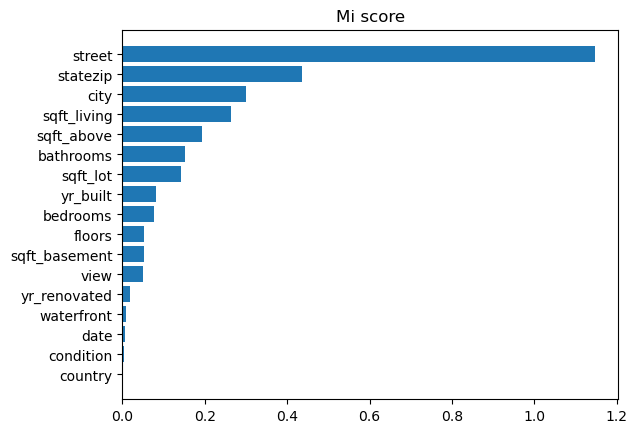

In [22]:
def plot_mi_score(score):
    score = score.sort_values(ascending = True)
    width = np.arange(len(score))
    ticks = list(score.index)
    plt.barh(width,score)
    plt.yticks(width, ticks)
    plt.title('Mi score')

plot_mi_score(mi_score)


 Data Analysis

<Axes: >

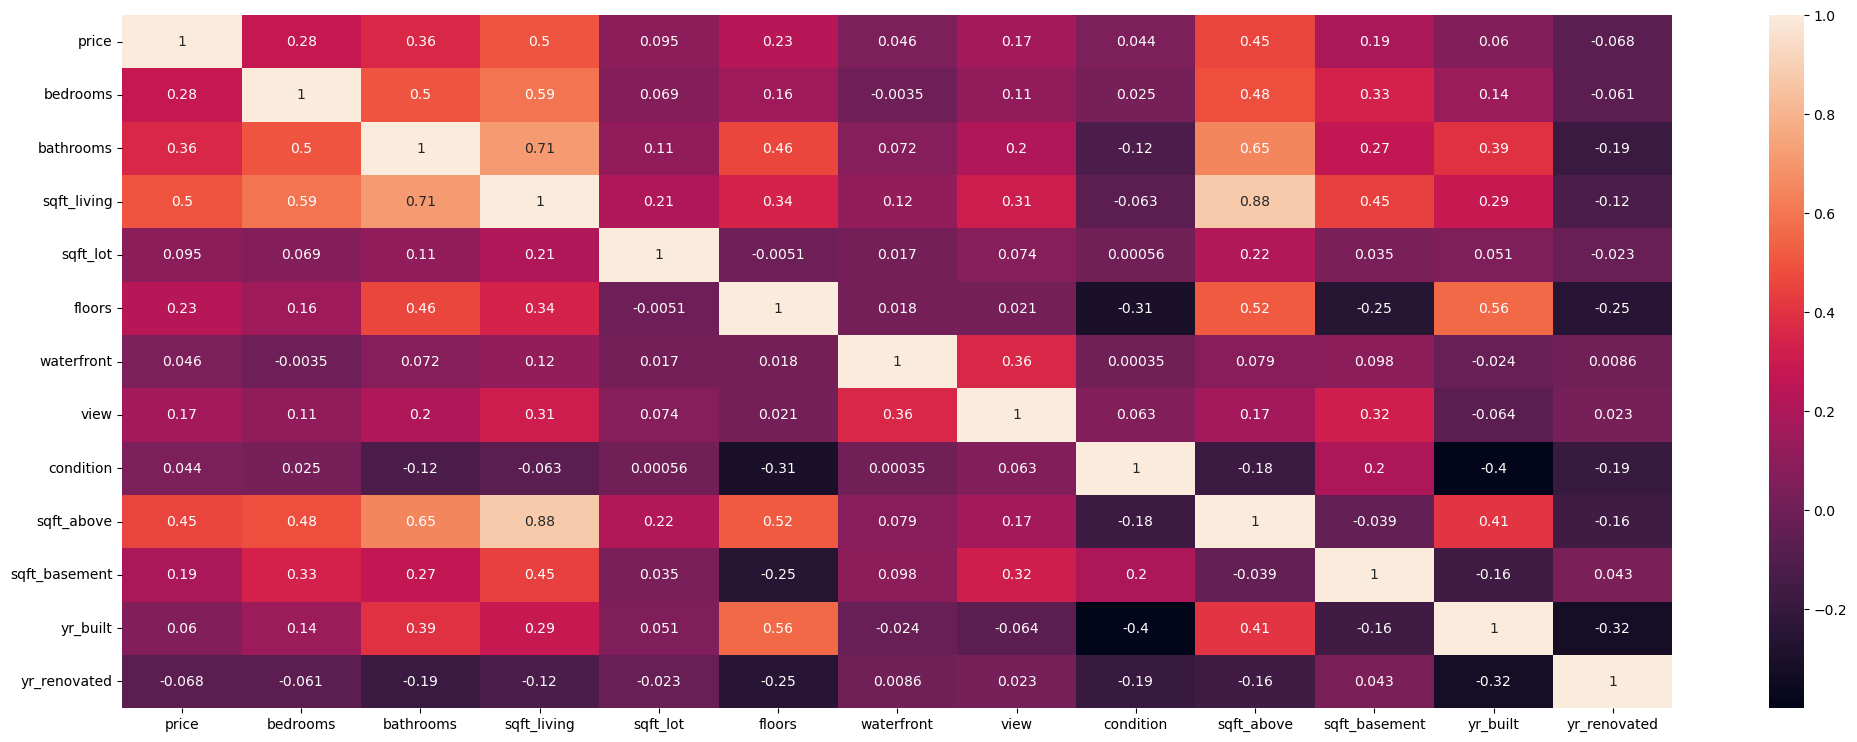

In [23]:
plt.figure(figsize=(25,9))
# print(df1.select_dtypes('number').corr())
sns.heatmap(df.select_dtypes('number').corr(),annot=True)

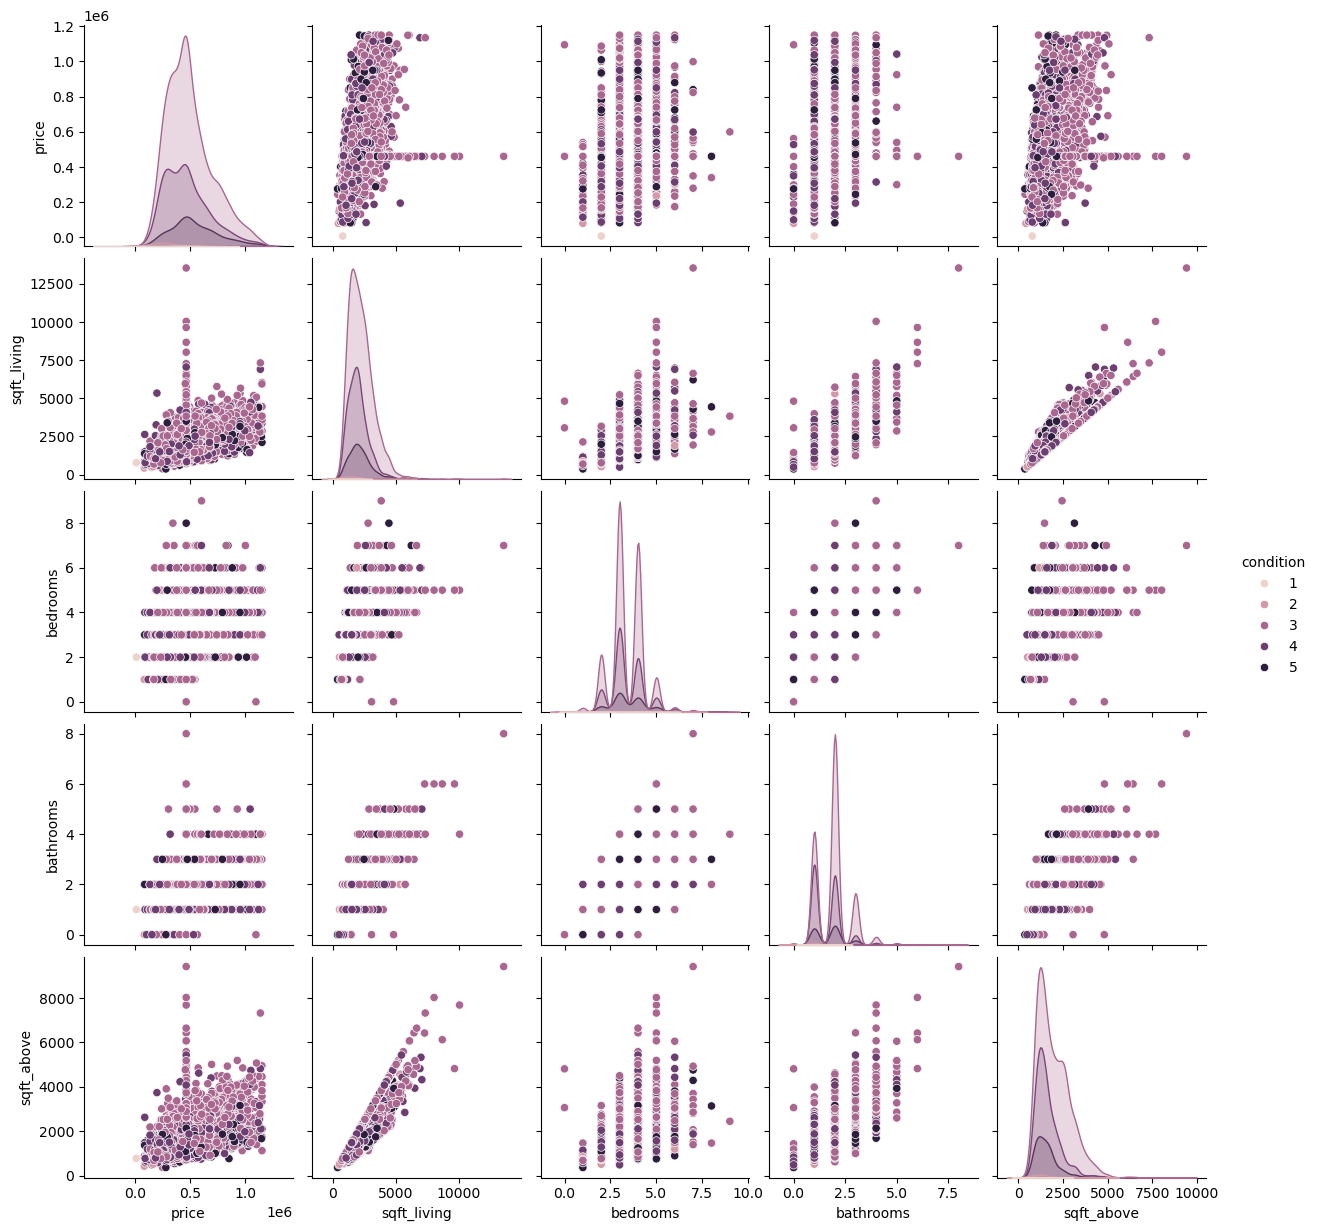

In [24]:
sns.pairplot(df, vars=["price", "sqft_living", "bedrooms", "bathrooms",'sqft_above'], hue="condition")

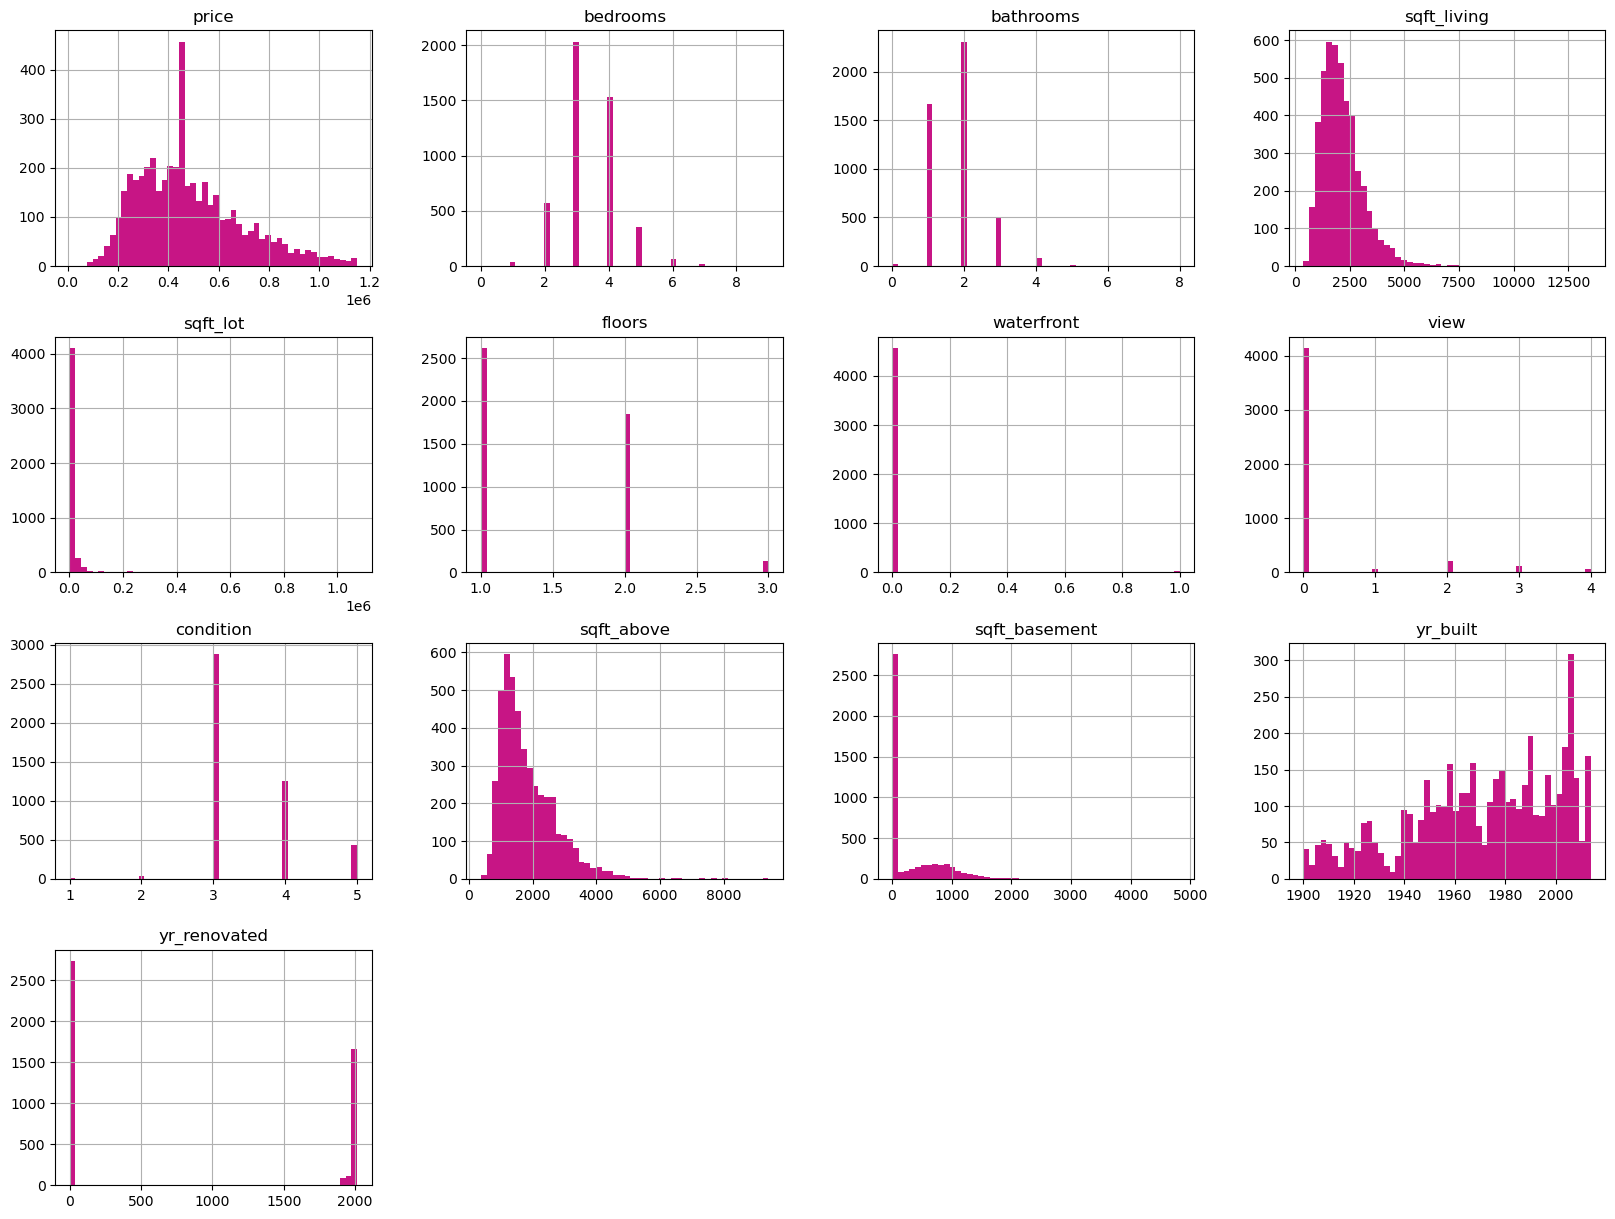

In [25]:
df.hist(bins=50, figsize=(20,15),color = 'mediumvioletred')
plt.show()


In [26]:
df.select_dtypes(include=['object', 'category'])

,date,street,city,statezip,country
0,2014-05-02 00:00:00,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,9105 170th Ave NE,Redmond,WA 98052,USA
...,...,...,...,...,...
4595,2014-07-09 00:00:00,501 N 143rd St,Seattle,WA 98133,USA
4596,2014-07-09 00:00:00,14855 SE 10th Pl,Bellevue,WA 98007,USA
4597,2014-07-09 00:00:00,759 Ilwaco Pl NE,Renton,WA 98059,USA
4598,2014-07-10 00:00:00,5148 S Creston St,Seattle,WA 98178,USA


In [27]:
df.country.unique()

array(['USA'], dtype=object)

In [28]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.000000,3,1,1340,7912,1,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,460943.461539,5,2,3650,9050,2,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.000000,3,2,1930,11947,1,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.000000,3,2,2000,8030,1,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.000000,4,2,1940,10500,1,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [29]:
#split Data
df.shape

(4600, 18)

In [30]:
df.head(1)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3,1,1340,7912,1,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA


In [31]:
y=df['price']

In [32]:
x = df.drop(['price', 'yr_renovated','condition', 'date', 'waterfront', 'sqft_basement', 'view', 'floors','country'], axis=1)
x.head(1)

,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_above,yr_built,street,city,statezip
0,3,1,1340,7912,1340,1955,18810 Densmore Ave N,Shoreline,WA 98133


In [33]:
encoder = MEstimateEncoder(cols=['street','statezip','city'], m=0.5)
x= encoder.fit_transform(x,y)

In [34]:
x.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_above,yr_built,street,city,statezip
0,3,1,1340,7912,1340,1955,370597.055398,397838.407158,375028.729944
1,5,2,3650,9050,3370,1921,469226.029757,505897.688366,662256.297716
2,3,2,1930,11947,1930,1966,389930.388732,301244.661812,312937.540546
3,3,2,2000,8030,1000,1963,441930.388732,639622.854879,537143.918630
4,4,2,1940,10500,1140,1976,528597.055398,633662.148403,622101.879120


Regression Models

In [35]:
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [36]:
# split the training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x.values, y.values, test_size=0.3, random_state=42)

In [37]:
#making dictionary of models
models = {
    'SVR':SVR(),
    'XGBRegressor':XGBRegressor(),
    'Ridge':Ridge(),
    'ElasticNet':ElasticNet(),
    'SGDRegressor':SGDRegressor(),
    'BayesianRidge':BayesianRidge(),
    'LinearRegression':LinearRegression(),
    'RandomForestRegressor':RandomForestRegressor()
}

In [38]:
#Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score


results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)


    
    results[name] = {
        "MAE": mae,
        "MSE": mse,
        "R2": r2, 

    }
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Mean Absolute Error (MAE): {metrics['MAE']}")
    print(f"  Mean Squared Error (MSE): {metrics['MSE']}")
    print(f"  R-squared (R2): {metrics['R2']}")
    print("-" * 50)

SVR:
  Mean Absolute Error (MAE): 159256.87788073655
  Mean Squared Error (MSE): 42415465339.63338
  R-squared (R2): -0.007933270563024397
--------------------------------------------------
XGBRegressor:
  Mean Absolute Error (MAE): 4445.558338286956
  Mean Squared Error (MSE): 240621226.90594774
  R-squared (R2): 0.9942820351430737
--------------------------------------------------
Ridge:
  Mean Absolute Error (MAE): 2559.9345720321817
  Mean Squared Error (MSE): 228961838.23622128
  R-squared (R2): 0.9945591012004785
--------------------------------------------------
ElasticNet:
  Mean Absolute Error (MAE): 2553.648732295239
  Mean Squared Error (MSE): 229220914.07958758
  R-squared (R2): 0.9945529446922323
--------------------------------------------------
SGDRegressor:
  Mean Absolute Error (MAE): 3.0528925600730854e+20
  Mean Squared Error (MSE): 9.907045294785375e+40
  R-squared (R2): -2.354245199393905e+30
--------------------------------------------------
BayesianRidge:
  Mean 

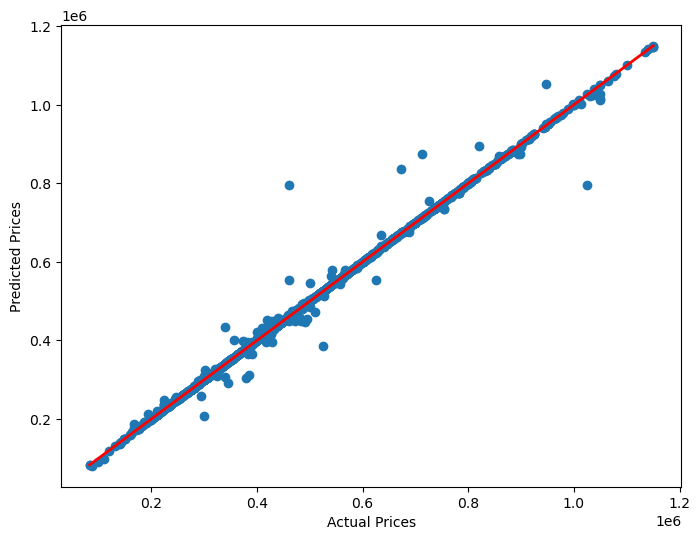

In [39]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.show()

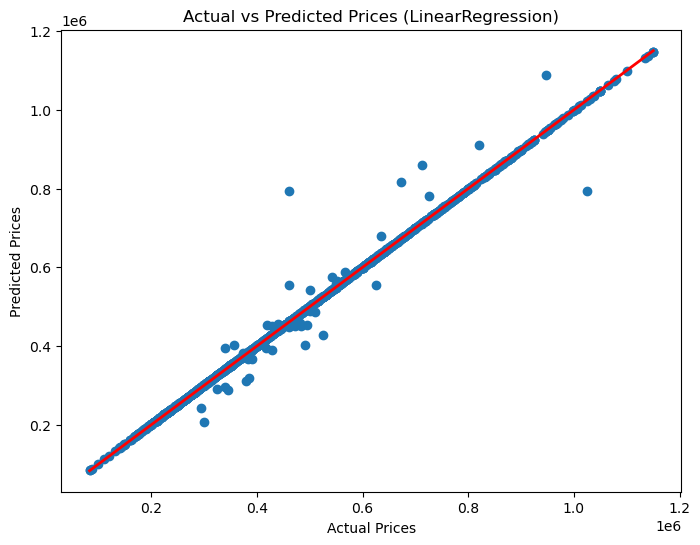

In [40]:
best_model_name = max(results, key=lambda k: results[k]['R2'])  
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Actual vs Predicted Prices ({best_model_name})')
plt.show()

In [41]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor


In [42]:
# Define the objective function
def objective(trial):
    # Define hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # Define the model
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    # Cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    score = cross_val_score(rf, X_train, y_train, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    return score.mean()  # Return the mean of negated MSE



In [349]:
# Create an Optuna study
study = optuna.create_study(direction='minimize')  # Change direction to minimize
study.optimize(objective, n_trials=10000)

# Best results
best_trial = study.best_trial
print(f"Best Trial Number: {best_trial.number}")
print(f"Best Parameters: {best_trial.params}")
print(f"Best Negative MSE: {best_trial.value:.4f}")  # Print negative MSE
print(f"Best RMSE: {(-best_trial.value) ** 0.5:.4f}")  # Convert to RMSE

[I 2025-01-29 10:03:58,248] A new study created in memory with name: no-name-75d4fbda-0fe0-418d-837d-8898b0d0cab2
[I 2025-01-29 10:04:04,671] Trial 0 finished with value: -828539536.7061313 and parameters: {'n_estimators': 142, 'max_depth': 37, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: -828539536.7061313.
[I 2025-01-29 10:04:08,913] Trial 1 finished with value: -822008622.218216 and parameters: {'n_estimators': 104, 'max_depth': 31, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: -828539536.7061313.
[I 2025-01-29 10:04:13,305] Trial 2 finished with value: -535945611.77555484 and parameters: {'n_estimators': 375, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: -828539536.7061313.
[I 2025-01-29 10:04:14,690] Trial 3 finished with value: -845938097.8960114 and parameters: {'n_estimators': 253, 'max_depth': 22, 

In [350]:
best_params = study.best_params
best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']
best_max_feature = best_params['max_features']

In [351]:
best_model = RandomForestRegressor(n_estimators = best_n_estimators, 
                                   max_depth = best_max_depth,
                                   min_samples_split = best_min_samples_split,
                                   min_samples_leaf = best_min_samples_leaf,
                                   max_features = best_max_feature
                                   )

In [352]:
best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=35, max_features='log2', min_samples_leaf=10,
                      min_samples_split=7, n_estimators=66)

In [353]:
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse - mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 17670.255535998534
Mean Squared Error: 239542683.78456342
R-squared: 0.9734958388683069
